In [7]:
# link to use: https://towardsdatascience.com/faq-build-a-handwritten-text-recognition-system-using-tensorflow-27648fb18519
# convert image to character segments: https://stackoverflow.com/questions/10964226/how-to-convert-an-image-into-character-segments
# KMNIST convolutional NN: https://github.com/rois-codh/kmnist/blob/master/benchmarks/kuzushiji_mnist_cnn.py


# DOWNLOAD THE KMNIST DATA BEFORE RUNNING THIS NOTEBOOK
https://github.com/rois-codh/kmnist/

# Preprocessing: Hiragana to Unicode Mapping

In [355]:
# create mappings from num to unicode, and syllable to unicode
map_unicode = {
    0:  u"\u3042", 1:  u"\u3044", 2:  u"\u3046", 3:  u"\u3048", 4:  u"\u304A",
    5:  u"\u304B", 6:  u"\u304D", 7:  u"\u304F", 8:  u"\u3051", 9:  u"\u3053",
    10: u"\u3055", 11: u"\u3057", 12: u"\u3059", 13: u"\u305B", 14: u"\u305D",
    15: u"\u305F", 16: u"\u3061", 17: u"\u3064", 18: u"\u3066", 19: u"\u3068",
    20: u"\u306A", 21: u"\u306B", 22: u"\u306C", 23: u"\u306D", 24: u"\u306E",
    25: u"\u306F", 26: u"\u3072", 27: u"\u3075", 28: u"\u3078", 29: u"\u307B",
    30: u"\u307E", 31: u"\u307F", 32: u"\u3080", 33: u"\u3081", 34: u"\u3082",
    35: u"\u3084", 36: u"\u3086", 37: u"\u3088", 38: u"\u3089", 39: u"\u308A",
    40: u"\u308B", 41: u"\u308C", 42: u"\u308D", 43: u"\u308F", 44: u"\u3090",
    45: u"\u3091", 46: u"\u3092", 47: u"\u3093", 48: u"\u309D"}

# print([map_unicode[i] for i in range(49)])

# list of all the basic sounds
chars = ["a", "i", "u", "e", "o",
         "ka", "ki", "ku", "ke", "ko",
         "sa", "shi", "su", "se", "so",
         "ta", "chi", "tsu", "te", "to",
         "na", "ni", "nu", "ne", "no",
         "ha", "hi", "fu", "he", "ho",
         "ma", "mi", "mu", "me", "mo",
         "ya", "yu", "yo",
         "ra", "ri", "ru", "re", "ro",
         "wa", "wi", "wu", "wo",
         "n"]

# a very long string of all the accents, split on space (\u3000)
st = "\u3060\u3000\u3062\u3000\u3065\u3000\u3067\u3000\u3069\u3000\u3070\u3000\u3073\u3000\u3076\u3000\u3079\u3000\u307c\u3000\u3071\u3000\u3074\u3000\u3077\u3000\u307a\u3000\u307d\u3000\u3056\u3000\u3058\u3000\u305a\u3000\u305c\u3000\u305e\u3000\u304c\u3000\u304e\u3000\u3050\u3000\u3052\u3000\u3054"
acc_list = st.split("\u3000")

# a list of all of the accent sounds
acc = ["da", "di", "du", "de", "do", 
       "pa", "pi", "pu", "pe", "po", 
       "ba", "bi", "bu", "be", "bo",
       "za", "ji", "zu", "ze", "zo",
       "ga", "gi", "gu", "ge", "go"]


map_num_char = dict()
map_unicode_char = dict()
map_acc = dict(zip(acc,lst))
map_char_num = dict()

# create mappings from phonetic to unicode, as well as from number to sound and vice versa (will help later)
for i in range(len(chars)):
    map_unicode_char[chars[i]] = map_unicode[i] 
    map_num_char[i] = chars[i]
    map_char_num[chars[i]] = i


# create a full mapping of all the possible hiragana
map_unicode_char.update(map_acc)

# print(map_unicode_char)

## Preprocessing: Image Segmentation and Contrast Enhancement

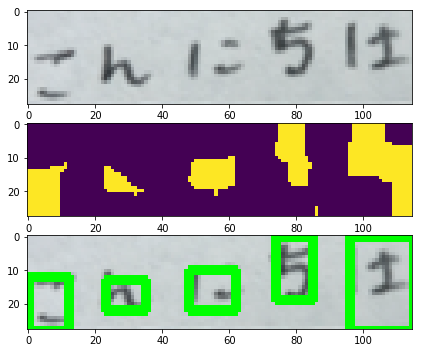

In [416]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from scipy.stats import mode

# Load the image
img = cv2.imread('hi.png')
img = np.append(img,[img[0]],axis = 0)

# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# smooth the image to avoid noises
gray = cv2.medianBlur(gray,5)

# Apply adaptive threshold
thresh = cv2.adaptiveThreshold(gray,255,1,1,61,2)
thresh_color = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

# manual cleanup
def cleanup(img):
    clean = np.zeros(np.shape(img))
    print(np.shape(img))
    for i in range(1, len(img)-1):
        for j in range(1, len(img[0])-1):
            neighbors = [img[i][j-1], 
                         img[i][j+1], 
                         img[i-1][j+1], 
                         img[i-1][j-1], 
                         img[i-1][j], 
                         img[i+1][j],
                         img[i+1][j+1], 
                         img[i+1][j-1]]
            if img[i][j] != 0 and 0 in neighbors:
                clean[i][j] = 0
            else:
                clean[i][j] = img[i][j]
    return clean

# thresh = cleanup(thresh)

# apply erosions and dilations to "blob" the characters
thresh = cv2.dilate(thresh,None, iterations = 4, anchor = (0, 1))
thresh = cv2.erode(thresh,None, iterations = 5)

# generate images of the transformation results
fig = plt.figure(figsize=(10,10))
fig.add_subplot(5,1,1)
plt.imshow(img, cmap = "gray")
fig.add_subplot(5,1,2)
plt.imshow(thresh)

# Find the contours
im, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
bounds = []

# For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    
    # not noise
    if w > 3:
        bounds.append((x,x+w))
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.rectangle(thresh_color,(x,y),(x+w,y+h),(0,255,0),2)

# sort the bounds by the lower coordinate
bounds = sorted(bounds)

# display the transformation results
fig.add_subplot(5,1,3)
plt.imshow(img)


# Preprocessing: Using Segmentation to Create Model-Applicable Test Images

In [433]:
# data cleanup

# get_bounds(b) uses the segmentation bounds b to generate 28 pixel boundaries for image width
def get_bounds(b):
    lo, hi = b[0], b[1]
    if hi > 100:
        width = hi - lo
        pad = (28 - width)
        lo -= pad
    
    if lo != 0 and hi < 100:
        width = hi - lo
        pad = (28 - width)//2
        lo -= pad
        hi += pad
        if hi - lo == 27:
            hi += 1    
    elif lo == 0:
        hi += (28 - hi)
        
    return lo,hi
    
# set_pix(im) uses custom thresholding to define the grayscale values in 
# range [0.0, 1.0] for the image im
def set_pix(im):
    for i in range(len(im)):
        for j in range(len(im[0])):
            val = 1-im[i][j]/255
            if val <= .3:
                im[i][j] = 0.0
            else:
                im[i][j] = val
    return im
 
# format_char(lo, hi) takes in the bounds for width and height from the segmentation and returns a 
# formatted character that can be directly passed into the trained model 
def format_char(lo, hi):
    char = img[:,lo:hi,:]
    
    if lo == 0:
        char[:,22:,:] = char[:,16:22,:]
    
    char = cv2.cvtColor(char,cv2.COLOR_BGR2GRAY)
    char = np.array(char, dtype=object)
    char = set_pix(char)

    char = char.reshape(1,28,28,1)
    char = np.array(char, dtype="float32")
    
    pic = char[0,:,:,0]
    
    return char, pic

##### get letters from image ##########
    
## ko
img = cv2.imread('hi.png')
img = np.append(img,[img[0]],axis = 0)
k0, k1 = get_bounds(bounds[0])
ko, im_ko = format_char(k0,k1)

## n
img = cv2.imread('hi.png')
img = np.append(img,[img[0]],axis = 0)
n0, n1 = get_bounds(bounds[1])
n, im_n = format_char(n0,n1)

## ni
ni0, ni1 = get_bounds(bounds[2])
ni, im_ni = format_char(ni0+2, ni1+2)

## chi
chi0, chi1 = get_bounds(bounds[3])
chi, im_chi = format_char(chi0, chi1)

## wa
wa0, wa1 = get_bounds(bounds[4])
wa, im_wa = format_char(wa0, wa1)

# automate the code to grab 28x28 images from the test image (hi) and condense it (deprecated)
def get_chars():
    char_list = []
    im_list = []
    for bound in bounds:
        img = cv2.imread('hi.png')
        img = np.append(img,[img[0]],axis = 0)
        b0, b1 = get_bounds(bound)
        char, im = format_char(b0,b1)
        char_list.append(char[0])
        im_list.append(im)
        img = cv2.imread('hi.png')
    return np.array(char_list), np.array(im_list)

# konnichiwa, images = get_chars()


def fix(im):
    for i in range(len(im)):
        for j in range(len(im[0])):
            val = im[i][j]
            if val <= .2:
                im[i][j] = 0.0
            else:
                im[i][j] = im[i][j]+.2
    return im


# scale images to stretch over full 28 x 28 pixel grid
# erode if necessary

im_ko = cv2.resize(im_ko, (50, 50))[50-28:,:28]
# im_ko = cv2.erode(im_ko,None, iterations = 1)
ko[0,:,:,0] = im_ko

im_ni = cv2.resize(im_ni, (50, 50))[10:10+28,11:11+28]
im_ni = fix(cv2.erode(im_ni,None, iterations = 1))
ni[0,:,:,0] = im_ni


im_chi = cv2.resize(im_chi, (28, 58))[10:10+28]
#im_chi = cv2.resize(im_chi, (28, 50))
# slic = cv2.resize(im_chi[:,6:21], (7, 28))

# im_chi[:,6:21] = 0
# im_chi[:,10:17] = slic

im_chi = cv2.erode(im_chi,None, iterations = 1)
im_chi = fix(im_chi)
im_chi = cv2.dilate(im_chi,None, iterations = 1)
im_chi = cv2.erode(im_chi,None, iterations = 1)

chi[0,:,:,0] = im_chi


im_wa = cv2.resize(im_wa, (50, 50))[5:5+28,14:14+28]
# im_wa = cv2.erode(im_wa,None, iterations = 1)

wa[0,:,:,0] = im_wa



# Neural Network Model: CNN for Hiragana Classification using KMNIST-49

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np

batch_size = 128
num_classes = 49
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

def load(f):
    return np.load(f)['arr_0']

# load the data from the K-49 training and test datasets
x_train = load('kmnist/k49-train-imgs.npz')
x_test = load('kmnist/k49-test-imgs.npz')
y_train = load('kmnist/k49-train-labels.npz')
y_test = load('kmnist/k49-test-labels.npz')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# scale the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('{} train samples, {} test samples'.format(len(x_train), len(x_test)))

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# model type is sequential
model = Sequential()

# 2D convolutional layer to process 2D input images
# 32 output channels, 3x3 moving window, activation function is a rectified linear unit

# size of input to the layer, determined above
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# another convolutional layer with 64 ouput channels this time

model.add(Conv2D(64, (3, 3), activation='relu'))

# add 2D max pooling layer with size of pooling in the x and y directions
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten the output to enter our fully connected layers
model.add(Flatten())

#declare our fully connected layers with 128 nodes
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# soft-max classification/ output layer
model.add(Dense(num_classes, activation='softmax'))


# loss function is the standard cross entropy for categorical class classification
# optimizer is Adadelta optimizer
# accuracy is the metric that will be calculated when we run evaluate on the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# pass in training data, batch size, number of epochs
# verbose set to 1 so information will be printed in console about training progress
# pass in test set
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

232365 train samples, 38547 test samples
Train on 232365 samples, validate on 38547 samples
Epoch 1/1
232365/232365 [==============================] - 1060s 5ms/step - loss: 0.9664 - acc: 0.7463 - val_loss: 0.6906 - val_acc: 0.8194
Train loss: 0.3250823049641429
Train accuracy: 0.9126202311021867
Test loss: 0.6906428534047478
Test accuracy: 0.819363374573948


# Analysis: Visualize Model Predictions using KMNIST Test Data

In [436]:
y_pred = model.predict(x_test)

Hiragana Predicted:  ひ


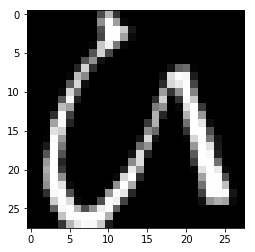

In [437]:
# close up on one image
plt.imshow(x_test[4,:,:,0], cmap = "gray")
print("Hiragana Predicted: ", map_unicode[np.argmax(y_pred[4])])

Predicted Classifications
[['と' 'ね' 'さ' 'ん']
 ['ひ' 'す' 'の' 'こ']
 ['の' 'け' 'と' 'か']
 ['す' 'を' 'へ' 'お']
 ['こ' 'さ' 'く' 'せ']
 ['ふ' 'き' 'の' 'つ']]

Actual Labels
[['と' 'ね' 'さ' 'み']
 ['ひ' 'す' 'の' 'こ']
 ['の' 'け' 'と' 'か']
 ['す' 'を' 'へ' 'お']
 ['こ' 'さ' 'て' 'せ']
 ['ふ' 'き' 'の' 'つ']]

Differences
[0 4] [3 2]


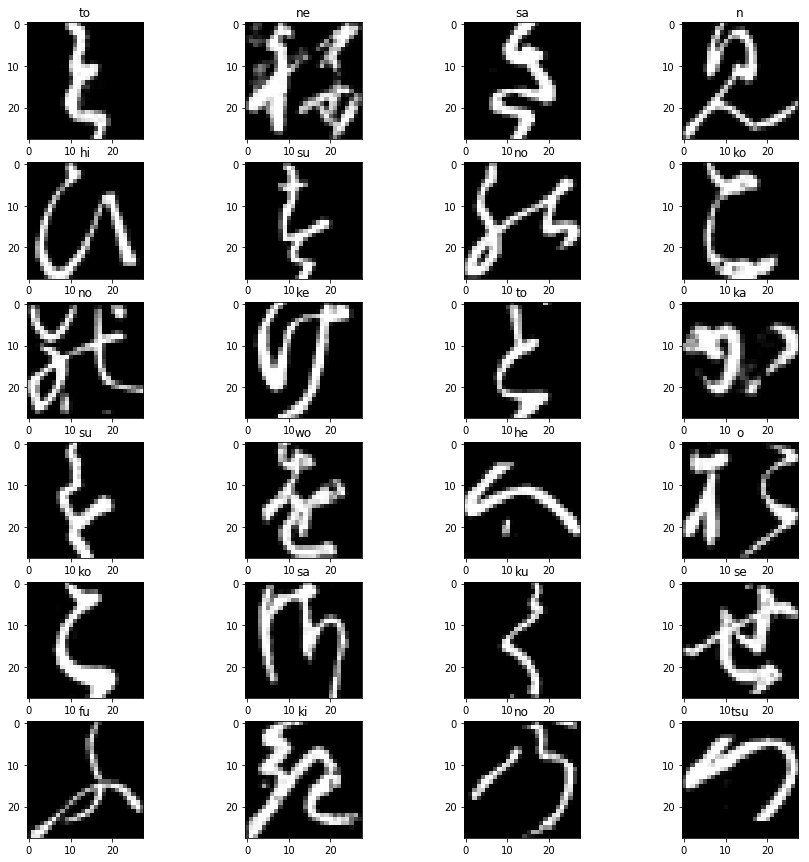

In [438]:
# -*- coding: utf-8 -*-

# view first 24 images and visually compare accuracy
fig = plt.figure(figsize=(15,15))
preds = [np.argmax(p) for p in y_pred[:24]]
titles = [map_num_char[i] for i in preds]
classes = [map_unicode[i] for i in preds]


act = [map_unicode[np.argmax(p)] for p in y_test[:24]]

print("Predicted Classifications")
print(np.array(classes).reshape(6,4))
print("")
print("Actual Labels")
print(np.array(act).reshape(6,4))

diffs = np.where(np.array(act).reshape(6,4) != np.array(classes).reshape(6,4))
print("")
print("Differences")
print(diffs[0], diffs[1])

for i in range(24):
    fig.add_subplot(6,4,i+1)
    plt.imshow(x_test[i,:,:,0], cmap = "gray")
    plt.title(titles[i])
    


# Analysis: Visualize Model Predictions using Custom Test Data

top 3 character numbers:  9 ,  37 ,  18
top 3 results for  ko :  こ ,  よ ,  て

top 3 character numbers:  47 ,  48 ,  7
top 3 results for  n :  ん ,  ゝ ,  く

top 3 character numbers:  21 ,  25 ,  15
top 3 results for  ni :  に ,  は ,  た

top 3 character numbers:  39 ,  2 ,  16
top 3 results for  chi :  り ,  う ,  ち

top 3 character numbers:  25 ,  8 ,  17
top 3 results for  wa :  は ,  け ,  つ



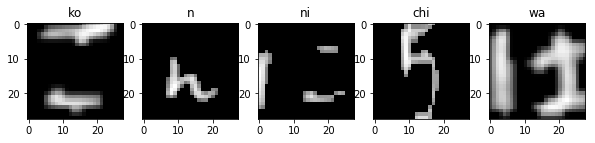

In [434]:
##### Predictions ##########

# predict_char(char, name) takes the pre processed image [char], plus the string pronunciation [name]
# and applies the trained neural network [model] to display the three most likely hiragana classifications
def predict_char(char, name):
    pred = model.predict(char)
    
    sort = pred.argsort()[0]
    res = sort[-1]
    snd = sort[-2]
    thr = sort[-3]
    
    m1 = map_unicode[res] 
    m2 = map_unicode[snd]
    m3 = map_unicode[thr]
    
    p = m1
    
    if map_unicode_char[name] == m2:
        p = m2
    elif map_unicode_char[name] == m3:
        p = m3
    
    print("top 3 character numbers: ", res, ", ", snd, ", ", thr)
    print("top 3 results for ",name, ": ", m1, ", ", m2, ", ", m3 )
    print("")
    
    return p

ko_pred = predict_char(ko, "ko")
n_pred = predict_char(n, "n")
ni_pred = predict_char(ni, "ni")
chi_pred = predict_char(chi, "chi")
wa_pred = predict_char(wa, "wa")

##### Display ##########

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,5,1)
plt.imshow(im_ko, cmap = "gray")
plt.title("ko")
fig.add_subplot(1,5,2)
plt.imshow(im_n, cmap = "gray")
plt.title("n")
fig.add_subplot(1,5,3)
plt.imshow(im_ni, cmap = "gray")
plt.title("ni")
fig.add_subplot(1,5,4)
plt.imshow(im_chi, cmap = "gray")
plt.title("chi")
fig.add_subplot(1,5,5)
plt.imshow(im_wa, cmap = "gray")
plt.title("wa");


# Evaluation: Accuracy Score and Balanced Accuracy

In [471]:
from sklearn.metrics import balanced_accuracy_score

# Keras evaluate model
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy Measures from builtin Evaluation')
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

# Balanced Accuracy
y_true = np.array([np.argmax(i) for i in y_test])
y_guess = np.array([np.argmax(i) for i in y_pred])

score = balanced_accuracy_score(y_true,y_guess)
print("Balanced Accuracy Score", score)


Accuracy Measures from builtin Evaluation
Train loss: 0.18172475299528312
Train accuracy: 0.9504916833432729
Test loss: 0.47950298333349256
Test accuracy: 0.8770851168811381
Balanced Accuracy Score 0.8643128097316521


# Evaluation: Confusion Matrix

In [469]:
from sklearn.metrics import confusion_matrix
from pandas import DataFrame

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_guess)
hiragana = [map_unicode[i] for i in range(49)]

# Display Results
df = DataFrame.from_records(cm, columns=hiragana)
df.insert(0, column = "Char", value = hiragana)
print("Generate Confusion Matrix")

# TODO: Analyze patterns in CM


df

Generate Confusion Matrix


,Char,あ,い,う,え,お,か,き,く,け,...,り,る,れ,ろ,わ,ゐ,ゑ,を,ん,ゝ
0,あ,926,3,2,0,2,0,0,0,3,...,0,0,0,0,0,0,0,3,0,0
1,い,0,938,0,0,1,1,0,0,2,...,2,0,4,0,0,0,0,0,1,0
2,う,0,0,953,0,0,8,0,0,0,...,5,0,0,0,0,0,0,0,0,1
3,え,0,0,0,102,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,11
4,お,9,0,0,0,905,3,0,0,1,...,0,1,2,0,2,0,0,1,0,0
5,か,7,0,23,0,11,833,0,0,2,...,32,15,0,3,0,0,0,0,0,4
6,き,0,1,0,0,0,0,842,1,18,...,2,3,3,0,0,0,0,4,0,1
7,く,0,0,1,2,0,3,0,900,1,...,4,0,0,0,0,0,0,0,4,7
8,け,1,0,1,1,1,3,7,2,615,...,8,2,0,0,0,1,0,21,1,0
9,こ,10,1,6,0,2,1,0,3,3,...,1,1,0,0,0,0,0,1,0,1


In [470]:
# save to csv
df.to_csv("cm.csv")

# Further Application: Machine Translation of Hiragana Phrases

In [337]:
##### TRANSLATION ######
from googletrans import Translator

translator = Translator()

#word = ["to", "te", "mo", "ya", "sa", "shi", "i", "hi", "to"]
# word = ["wa", "ta", "shi", "no", "na", "ma", "e", "ha"]
# word = ["wa", "ta", "shi", "te"]
# tring = "".join([map_unicode_char[st] for st in word])

string = ko_pred+n_pred+ni_pred+chi_pred+wa_pred

print(string)

print(translator.translate(string + " Laasya").text)

こんにちは
Hello Laasya
